In [1]:
# Run only if packages are missing
# %pip install numpy pandas scikit-learn matplotlib scipy liac-arff scikit-multilearn


In [2]:
DATA_SOURCE = "synthetic"   # change to "real" when using actual Yeast files
print("DATA_SOURCE =", DATA_SOURCE)


DATA_SOURCE = synthetic


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.neighbors import NearestNeighbors

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def summarize(X, Y):
    print("Shapes -> X:", X.shape, " Y:", Y.shape)
    Y_np = Y.values.astype(int) if isinstance(Y, pd.DataFrame) else np.asarray(Y).astype(int)
    n_labels = Y_np.shape[1]
    card = Y_np.sum(axis=1).mean()
    dens = card / n_labels
    print(f"Labels: {n_labels} | Label Cardinality: {card:.3f} | Label Density: {dens:.3f}")

def most_frequent_single_labels(Y_df):
    freqs = Y_df.sum(axis=0).sort_values(ascending=False)
    return list(freqs.index[:2]), freqs

def most_frequent_label_combo(Y_df):
    tuples = []
    for _, row in Y_df.iterrows():
        labs = tuple(sorted(list(Y_df.columns[row.values.astype(bool)])))
        if len(labs) >= 2:
            tuples.append(labs)
    if not tuples:
        return None
    c = Counter(tuples)
    combo, _ = c.most_common(1)[0]
    return combo

def build_coloring_index(Y_df, top_two_single, top_multi_combo):
    cats = []
    for _, row in Y_df.iterrows():
        active = list(Y_df.columns[row.values.astype(bool)])
        if len(active) == 1 and active[0] in top_two_single:
            cats.append(active[0])
        elif len(active) >= 2 and top_multi_combo is not None and tuple(sorted(active)) == tuple(sorted(top_multi_combo)):
            cats.append(" & ".join(top_multi_combo))
        else:
            cats.append("Other")
    return pd.Series(cats, name="viz_class")

def plot_embedding(emb2d, colors, title="2D Embedding"):
    fig, ax = plt.subplots(figsize=(8,6))
    unique = pd.unique(colors)
    for u in unique:
        idx = (colors == u)
        ax.scatter(emb2d[idx, 0], emb2d[idx, 1], s=12, label=str(u), alpha=0.85)
    ax.legend(title="Class", markerscale=1.5, fontsize=9, loc="best")
    ax.set_title(title); ax.set_xlabel("Dim 1"); ax.set_ylabel("Dim 2")
    plt.show()

def knn_metrics(emb2d, labels, k=15):
    """Returns (mean_kNN_dist, majority_mismatch_flag, neighbor_label_entropy)."""
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(emb2d)
    dists, idxs = nbrs.kneighbors(emb2d)
    d_local = dists[:, 1:].mean(axis=1)       # exclude self
    idx_local = idxs[:, 1:]
    lbl = labels.values
    from collections import Counter as C
    maj_diff, entropy = [], []
    for i in range(emb2d.shape[0]):
        neigh_lbls = lbl[idx_local[i]]
        counts = C(neigh_lbls)
        maj = counts.most_common(1)[0][0]
        maj_diff.append(1 if lbl[i] != maj else 0)
        total = sum(counts.values())
        ent = 0.0
        for c in counts.values():
            p = c/total
            ent -= p * np.log2(p)
        entropy.append(ent)
    return np.array(d_local), np.array(maj_diff), np.array(entropy)


In [4]:
X_real = Y_real = feature_names = label_names = None

if DATA_SOURCE == "real":
    try:
        CSV_X = Path("yeast_X.csv"); CSV_Y = Path("yeast_Y.csv")
        if CSV_X.exists() and CSV_Y.exists():
            X_real = pd.read_csv(CSV_X)
            Y_real = pd.read_csv(CSV_Y).astype(int)
            feature_names = list(X_real.columns)
            label_names = list(Y_real.columns)
            X_real = X_real.values
            print("Loaded local CSVs.")
        else:
            try:
                import arff
                ARFF_PATH = Path("yeast.arff")
                if ARFF_PATH.exists():
                    with open(ARFF_PATH, 'r', encoding='utf-8') as f:
                        data = arff.load(f)
                    df = pd.DataFrame(data['data'], columns=[a[0] for a in data['attributes']])
                    X_real = df.iloc[:, :-14].astype(float).values
                    Y_real = df.iloc[:, -14:].astype(int)
                    feature_names = list(df.columns[:-14])
                    label_names = list(df.columns[-14:])
                    print("Loaded local ARFF.")
                else:
                    from skmultilearn.dataset import load_from_arff
                    X_real, Y_sparse = load_from_arff(str(ARFF_PATH), label_count=14, endian="little")
                    X_real = X_real.toarray()
                    Y_real = pd.DataFrame(Y_sparse.toarray(), columns=[f"Label_{i+1}" for i in range(14)])
                    feature_names = [f"f{i+1}" for i in range(X_real.shape[1])]
                    label_names = list(Y_real.columns)
                    print("Loaded via skmultilearn (ARFF).")
            except Exception as e2:
                raise FileNotFoundError("Place yeast_X.csv & yeast_Y.csv or yeast.arff next to this notebook.") from e2
    except Exception as e:
        print("ERROR loading real data:", e)
        raise

    print("Real data summary:")
    summarize(X_real, Y_real if isinstance(Y_real, pd.DataFrame) else pd.DataFrame(Y_real))


In [5]:
X_syn = Y_syn = None
feature_names_syn = [f"f{i+1}" for i in range(86)]
label_names_syn   = [f"L{i+1}" for i in range(14)]

if DATA_SOURCE == "synthetic":
    n, d, L, k = 2400, 86, 14, 8
    centers = np.random.randn(k, d) * 2.0
    cluster_labels = [np.random.choice(np.arange(L), size=np.random.randint(1, 4), replace=False) for _ in range(k)]
    X_list, Y_list = [], []
    for i in range(n):
        c = np.random.randint(0, k)
        x = centers[c] + np.random.randn(d) * np.random.uniform(0.4, 1.2)
        y = np.zeros(L, dtype=int)
        y[cluster_labels[c]] = 1
        if np.random.rand() < 0.25:
            extra = np.random.choice(np.arange(L), size=np.random.randint(1, 3), replace=False)
            y[extra] = 1
        X_list.append(x); Y_list.append(y)
    X_syn = np.vstack(X_list)
    Y_syn = pd.DataFrame(np.vstack(Y_list), columns=label_names_syn)

    # Inject feature outliers + label noise
    n_out = 25
    X_syn[:n_out] = np.random.randn(n_out, d) * 6.0 + np.random.randn(1, d) * 10.0
    flips = (np.random.rand(*Y_syn.shape) < 0.05).astype(int)
    Y_syn = pd.DataFrame((Y_syn.values ^ flips), columns=label_names_syn)

    print("Synthetic data summary:")
    summarize(X_syn, Y_syn)


Synthetic data summary:
Shapes -> X: (2400, 86)  Y: (2400, 14)
Labels: 14 | Label Cardinality: 2.463 | Label Density: 0.176


In [6]:
if DATA_SOURCE == "real":
    X = X_real
    Y = Y_real if isinstance(Y_real, pd.DataFrame) else pd.DataFrame(Y_real, columns=label_names or [f"L{i+1}" for i in range(14)])
    feature_names_active = feature_names or [f"f{i+1}" for i in range(X.shape[1])]
    label_names_active   = list(Y.columns)
elif DATA_SOURCE == "synthetic":
    X = X_syn
    Y = Y_syn
    feature_names_active = feature_names_syn
    label_names_active   = label_names_syn
else:
    raise ValueError("DATA_SOURCE must be 'real' or 'synthetic'")

print("Active dataset shapes:", X.shape, Y.shape)


Active dataset shapes: (2400, 86) (2400, 14)


In [7]:
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])
print("Number of labels:",  Y.shape[1])


Number of samples: 2400
Number of features: 86
Number of labels: 14


In [8]:
Y_df = Y.copy()
top_two_single, single_freqs = most_frequent_single_labels(Y_df)
top_multi = most_frequent_label_combo(Y_df)

print("Top two single labels:", top_two_single)
print("Most frequent multi-label combo:", top_multi)

viz_classes = build_coloring_index(Y_df, top_two_single, top_multi)
viz_classes.value_counts()


Top two single labels: ['L11', 'L4']
Most frequent multi-label combo: ('L11', 'L9')


viz_class
Other       2035
L11 & L9     133
L11          131
L4           101
Name: count, dtype: int64

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:2, :5]  # peek


array([[ 4.74336398, -4.26218825,  1.02814999, -8.73035177,  0.76695034],
       [ 2.3677367 ,  0.20445382,  1.53446111, -3.37129558, -0.31265515]])

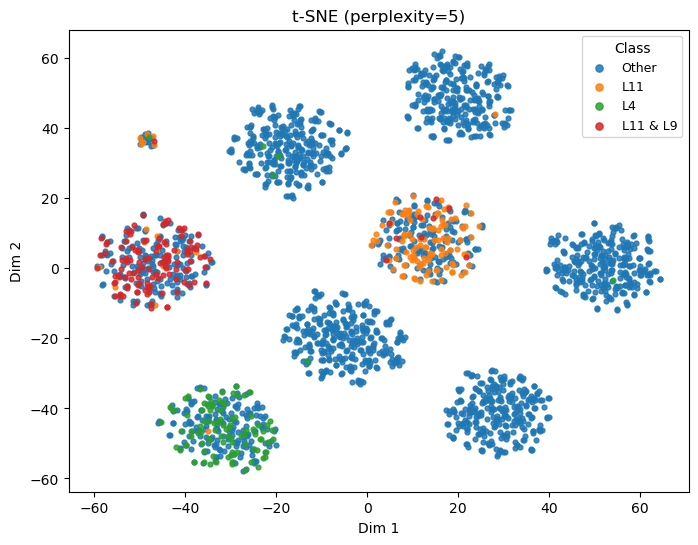

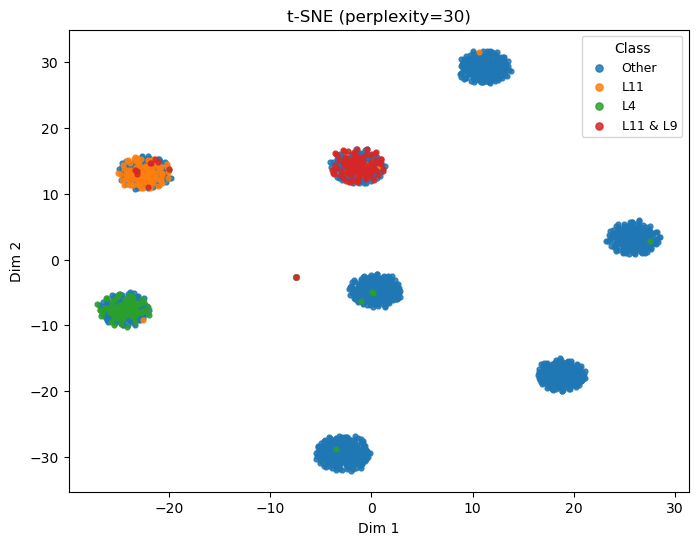

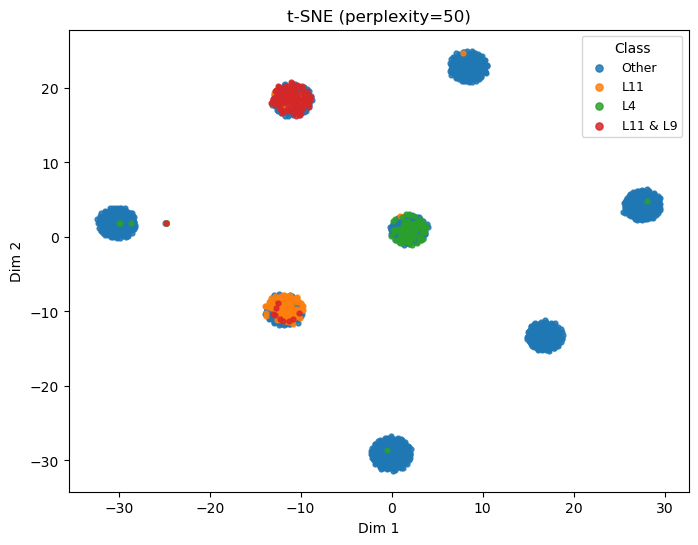

In [10]:
perplexities = [5, 30, 50]
tsne_embeddings = {}
for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, learning_rate="auto", init="pca", random_state=RANDOM_STATE)
    emb = tsne.fit_transform(X_scaled)
    tsne_embeddings[p] = emb
    plot_embedding(emb, viz_classes.values, title=f"t-SNE (perplexity={p})")


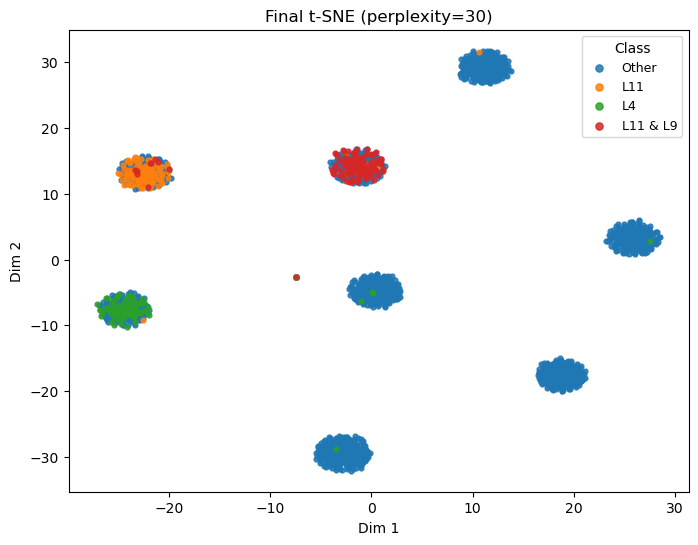

In [11]:
FINAL_P = 30   # adjust if your visuals suggest otherwise
tsne_final = TSNE(n_components=2, perplexity=FINAL_P, learning_rate="auto", init="pca", random_state=RANDOM_STATE)
TSNE_2D = tsne_final.fit_transform(X_scaled)
plot_embedding(TSNE_2D, viz_classes.values, title=f"Final t-SNE (perplexity={FINAL_P})")


In [12]:
k = 15
d_local, maj_diff, ent = knn_metrics(TSNE_2D, viz_classes, k=k)

thr_out = np.quantile(d_local, 0.99)  # top 1% outlier score
thr_ent = np.quantile(ent, 0.95)      # top 5% entropy

flags = pd.DataFrame({
    "viz_class": viz_classes.values,
    "outlier_score": d_local,
    "ambiguous": (maj_diff == 1).astype(int),
    "entropy": ent,
    "is_outlier": (d_local >= thr_out).astype(int),
    "is_mixed": (ent >= thr_ent).astype(int)
})
flags.head()


,viz_class,outlier_score,ambiguous,entropy,is_outlier,is_mixed
0,Other,0.001993,0,1.574417,0,1
1,Other,0.004247,0,1.198117,0,0
2,Other,0.001698,0,1.574417,0,1
3,L11,0.001853,1,1.521641,0,1
4,Other,0.002730,0,1.521641,0,1


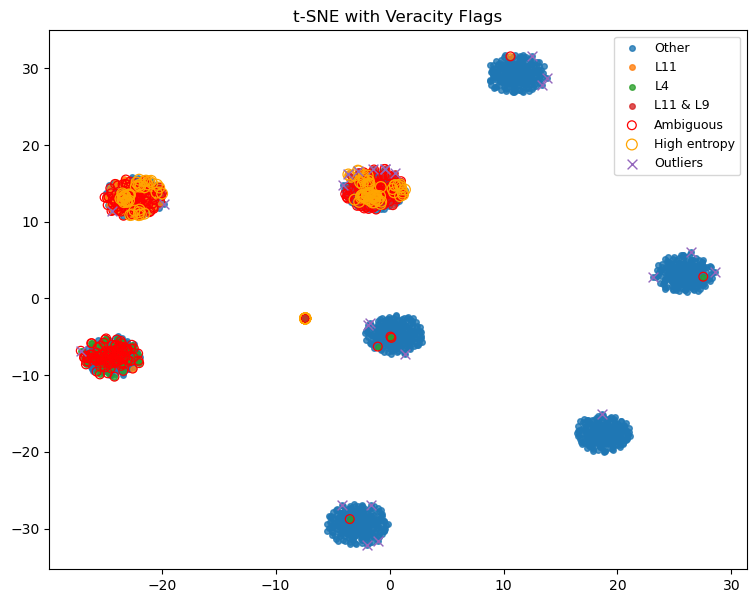

In [13]:
fig, ax = plt.subplots(figsize=(9,7))
unique = pd.unique(viz_classes.values)
for u in unique:
    idx = (viz_classes.values == u)
    ax.scatter(TSNE_2D[idx,0], TSNE_2D[idx,1], s=16, label=str(u), alpha=0.8)

amb_idx = flags["ambiguous"].values.astype(bool)
ax.scatter(TSNE_2D[amb_idx,0], TSNE_2D[amb_idx,1], s=40, facecolors="none", edgecolors="red", linewidths=0.9, label="Ambiguous")

mix_idx = flags["is_mixed"].values.astype(bool)
ax.scatter(TSNE_2D[mix_idx,0], TSNE_2D[mix_idx,1], s=60, facecolors="none", edgecolors="orange", linewidths=0.9, label="High entropy")

out_idx = flags["is_outlier"].values.astype(bool)
ax.scatter(TSNE_2D[out_idx,0], TSNE_2D[out_idx,1], s=50, marker="x", linewidths=1.0, label="Outliers")

ax.set_title("t-SNE with Veracity Flags")
ax.legend(loc="best", fontsize=9)
plt.show()


C:\Users\athir\anaconda3\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 9 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\athir\anaconda3\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\athir\anaconda3\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\athir\anaconda3\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\athir\anacon

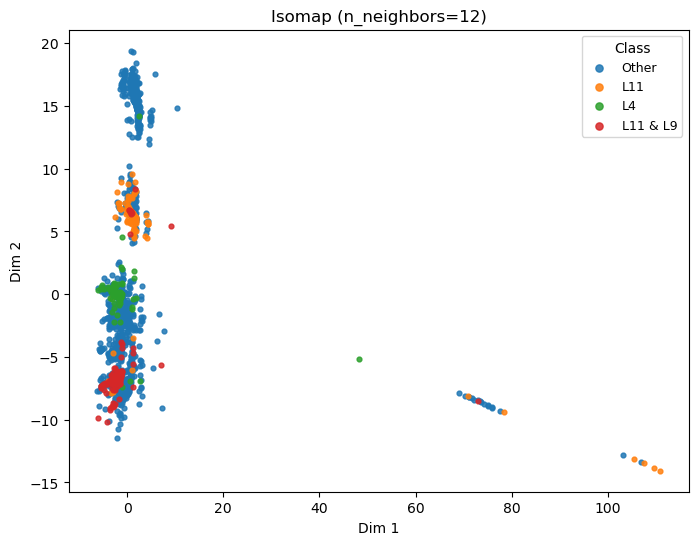

In [14]:
N_NEI = 12
isomap = Isomap(n_neighbors=N_NEI, n_components=2)
ISOMAP_2D = isomap.fit_transform(X_scaled)
plot_embedding(ISOMAP_2D, viz_classes.values, title=f"Isomap (n_neighbors={N_NEI})")


In [15]:
d_iso, maj_iso, ent_iso = knn_metrics(ISOMAP_2D, viz_classes, k=15)
pd.DataFrame({"iso_outlier_score": d_iso, "iso_entropy": ent_iso}).describe()


,iso_outlier_score,iso_entropy
count,2400.000000,2400.000000
mean,0.352134,0.412693
std,1.259064,0.463607
min,0.044273,0.000000
25%,0.105497,0.000000
50%,0.153213,0.000000
75%,0.299768,0.863121
max,24.677269,1.448816


```markdown
# Discussion

## 1) Global vs Local Structure (Isomap vs t-SNE)

- **What each preserves**
  - **t-SNE** prioritizes **local neighborhoods**: keeps nearby points close, even if long-range geometry is distorted. Great for revealing **tight clusters** and local mixing.
  - **Isomap** preserves **global geodesic structure**: builds a k-NN graph and embeds shortest-path (manifold) distances, so **overall layout/gradients** are more faithful.

- **How this looks in plots**
  - If data follow a **continuous progression** (e.g., a biological gradient), **Isomap** tends to show a **smooth arc/curve** or ordered band; **t-SNE** may split the same continuum into **multiple islands**.
  - If data are truly **clustered**, **t-SNE** often shows **cleaner, more separated blobs**; **Isomap** may connect them along the manifold, hinting at **global relationships** between clusters.

- **Takeaway**
  - Use **t-SNE** for **cluster separability** and inspecting **local confusions** (noisy/mixed neighborhoods).
  - Use **Isomap** for **macro-structure** (trajectories, branches, global trends) that informs **feature engineering** or model design.

---

## 2) Manifold Curvature & Classifier Complexity

- **High curvature** in Isomap (twists, folds, S-shapes) indicates the data live on a **non-linear manifold** in feature space.
- **Model implications**
  - **Linear models** (e.g., plain logistic regression) likely **underfit**—their hyperplanes can’t bend with the manifold.
  - Prefer **non-linear** decision functions:
    - **Kernels** (RBF/Poly SVM), **tree ensembles** (RF/GBM), or **neural nets** (with regularization).
    - **Local models** (k-NN, local regression) can track curvature if neighborhoods are well-sampled.
  - Consider **feature learning** (autoencoders, supervised embeddings) or **manifold-aware** steps to “unfold” the data into a space where classes are more linearly separable.
- **Operational tip**
  - Pronounced curvature in Isomap + fragmented t-SNE clusters ⇒ expect to need **non-linear capacity** and **careful regularization** to avoid overfitting the bends.

---

## 3) Mixed / High-Entropy Areas & Expected Model Difficulty

- **What “mixed/high-entropy” means**
  - In a local k-NN neighborhood on the embedding, **label entropy** measures class heterogeneity. **High entropy** = many different labels co-occur locally.
  - These regions signal **intrinsic ambiguity** (true biological overlap) or **data issues** (noisy/ambiguous labels).

- **Consequences for learning**
  - Expect **higher Bayes error**: even the optimal classifier misclassifies some points.
  - Models show **lower confidence** and **unstable predictions**; calibration may drift.
  - In **multi-label** settings, overlap can be legitimate co-occurrence; forcing hard separation may **hurt recall**.

- **Practical responses**
  - **Acknowledge limits** in accuracy near high-entropy zones; report per-region or uncertainty-aware metrics.
  - Use **uncertainty-aware training/evaluation**:
    - **Calibrated probabilities**, **threshold tuning** per label, **macro/micro-F1**, **PR-AUC**.
    - **Robust/focal losses** or **class-balanced losses** if minority labels are swamped locally.
  - **Clean or soften labels** where feasible (active-learning audits, smoothing, weak supervision).
  - Prefer **multi-label-aware** methods (classifier chains, label powerset) to model co-occurrence rather than forcing artificial separation.
